In [1]:
%matplotlib inline
import pandas as pd
import csv as csv
import numpy as np
from matplotlib import pyplot as plt
#import seaborn as sns
#from sklearn import datasets, linear_model
import matplotlib
import matplotlib.pylab as pl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
#import sqlite3

In [2]:
import glob

In [3]:
path = '../csv/2015/'
all_files = glob.glob(path + '*')
df_list = []

ds = pd.DataFrame()

for f in all_files:
    df = pd.read_csv(f,index_col=None,header=0)
    df_list.append(df)

ds = pd.concat(df_list).reset_index()

In [4]:
ds = ds.drop(['index','Unnamed: 8'],axis=1)
ds = ds.drop_duplicates()

lcase_col = [x.lower() for x in ds.columns]
ds.columns = lcase_col

In [5]:
airports = pd.read_csv('../csv/airports.csv',header=0)
carriers = pd.read_csv('../csv/carriers2.csv',header=0)

In [6]:
airports = airports[airports['country']=='USA']
airports = airports.drop('country',axis=1)

In [7]:
def color_route(x,y):
    return float(x)/float(y)

def color_route_log(x,y):
    return np.log(float(x))/np.log(float(y))

In [16]:
routes_del = ds.groupby(['origin','dest']).agg({
        'arr_del15':'sum','dep_time':'count'
    }).reset_index().rename(columns={'origin':'orig','dep_time':'N_flights'})

In [17]:
len(routes_del)

4696

In [18]:
routes_del.head()

,orig,dest,N_flights,arr_del15
0,ABE,ATL,978,150
1,ABE,DTW,772,147
2,ABE,ORD,725,145
3,ABI,DFW,2430,380
4,ABQ,ATL,891,83


In [19]:
airports = airports.rename(columns={'iata':'orig'})

routes_del = pd.merge(routes_del,airports,on=['orig'])
routes_del = routes_del.drop(['city','state','airport'],axis=1)
routes_del = routes_del.rename(columns={'lat':'orig_lat','long':'orig_lon'})

airports = airports.rename(columns={'orig':'dest'})

routes_del = pd.merge(routes_del,airports,on=['dest'])
routes_del = routes_del.drop(['city','state','airport'],axis=1)
routes_del = routes_del.rename(columns={'lat':'dest_lat','long':'dest_lon'})

In [31]:
routes_del['frac_del'] = routes_del['arr_del15'].apply(lambda x:float(x)) / \
                            routes_del['N_flights'].apply(lambda y:float(y))

In [32]:
len(routes_del.loc[routes_del['N_flights']<=120])

664

In [33]:
reducted_routes_del = routes_del[routes_del['N_flights']>120] #about 1 flight every 3 days

In [12]:
def color_route3(x):
    if x>.3:
        return ('indianred',2.0,.5)
    else:
        return ('royalblue',.6,.2)

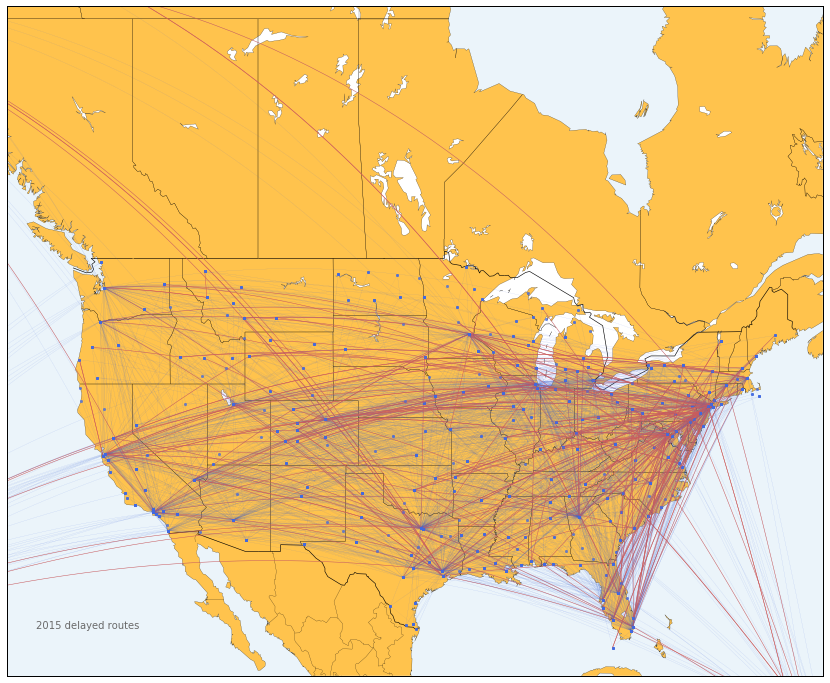

In [99]:
routes2 = routes_del#.sample(500)#[routes_del['frac_del']>.2]

fig = plt.figure(figsize=(18,12))

xbuf = 0.2
ybuf = 0.1
minlat = np.min([routes2.orig_lat.min(),  routes2.dest_lat.min()])
minlon = np.min([routes2.orig_lon.min(), routes2.dest_lon.min()])
maxlat = np.max([routes2.orig_lat.max(),  routes2.dest_lat.max()])
maxlon = np.max([routes2.orig_lon.max(), routes2.dest_lon.max()])
width = maxlon - minlon
height = maxlat - minlat

maxflights = float(routes2.N_flights.max())
maxdel = routes_del.frac_del.max()
meddel = routes_del.frac_del.mean()

m = Basemap(llcrnrlon = -130,#minlon - width* xbuf,
            llcrnrlat = 22.5,#minlat - height*ybuf,
            urcrnrlon = -65.0,#maxlon + width* xbuf,
            urcrnrlat = 60.5,#maxlat + height*ybuf,
            projection= 'merc',
            resolution='l',
            lat_0=minlat + height/2,
            lon_0=minlon + width/2
)

line_thickness=.2

continent_color = '#ffc34d'
route_color = 'royalblue'

m.drawmapboundary(fill_color='#EBF4FA')
m.drawcoastlines(linewidth=line_thickness)
m.drawstates(linewidth=line_thickness)
m.drawcountries(.6)
m.fillcontinents(color=continent_color)

for idx, f in routes2.iterrows():
    m.drawgreatcircle(f.orig_lon, f.orig_lat, f.dest_lon, f.dest_lat, linewidth=color_route3(f.frac_del)[2],
                      #alpha=1,
                      #alpha = color_route_log(f.N_flights,maxflights),
                      alpha=color_route3(f.frac_del)[1],
                      color=color_route3(f.frac_del)[0])
    m.plot(*m(f.orig_lon, f.orig_lat), color='royalblue', alpha=.5, marker='o', markersize=3, markeredgewidth=0.0)
    m.plot(*m(f.dest_lon, f.dest_lat), color='royalblue', alpha=.5, marker='o', markersize=3, markeredgewidth=0.0)

fig.text(0.22, 0.18, "2015 delayed routes", 
        ha='left', color='dimgrey', style='normal')

plt.savefig('flights.png', dpi=500, frameon=False, transparent=False, bbox_inches='tight', pad_inches=0.2)

In [8]:
routes_airline = ds[ds['unique_carrier']=='NK'].groupby(['origin','dest']).agg({
        'arr_del15':'sum','dep_time':'count'
    }).reset_index().rename(columns={'origin':'orig','dep_time':'N_flights'})

In [10]:
airports = airports.rename(columns={'iata':'orig'})

routes_airline = pd.merge(routes_airline,airports,on=['orig'])
routes_airline = routes_airline.drop(['city','state','airport'],axis=1)
routes_airline = routes_airline.rename(columns={'lat':'orig_lat','long':'orig_lon'})

airports = airports.rename(columns={'orig':'dest'})

routes_airline = pd.merge(routes_airline,airports,on=['dest'])
routes_airline = routes_airline.drop(['city','state','airport'],axis=1)
routes_airline = routes_airline.rename(columns={'lat':'dest_lat','long':'dest_lon'})

In [14]:
routes_airline['frac_del'] = routes_airline['arr_del15'].apply(lambda x:float(x)) / \
                            routes_airline['N_flights'].apply(lambda y:float(y))

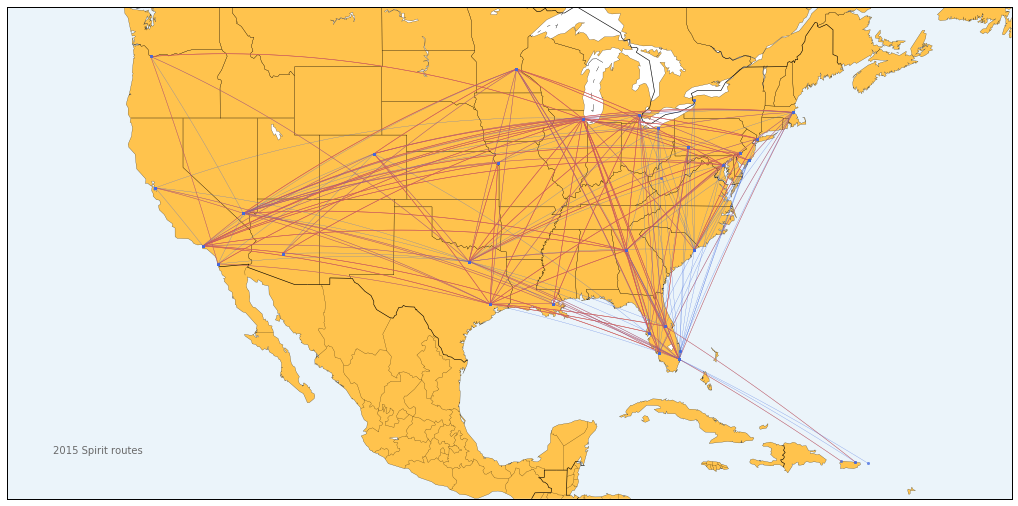

In [17]:
routes2 = routes_airline

fig = plt.figure(figsize=(18,12))

xbuf = 0.2
ybuf = 0.1
minlat = np.min([routes2.orig_lat.min(),  routes2.dest_lat.min()])
minlon = np.min([routes2.orig_lon.min(), routes2.dest_lon.min()])
maxlat = np.max([routes2.orig_lat.max(),  routes2.dest_lat.max()])
maxlon = np.max([routes2.orig_lon.max(), routes2.dest_lon.max()])
width = maxlon - minlon
height = maxlat - minlat

maxflights = float(routes2.N_flights.max())
maxdel = routes_airline.frac_del.max()
meddel = routes_airline.frac_del.mean()

m = Basemap(llcrnrlon = minlon - width* xbuf,
            llcrnrlat = minlat - height*ybuf,
            urcrnrlon = maxlon + width* xbuf,
            urcrnrlat = maxlat + height*ybuf,
            projection= 'merc',
            resolution='l',
            lat_0=minlat + height/2,
            lon_0=minlon + width/2
)

line_thickness=.2

continent_color = '#ffc34d'
route_color = 'royalblue'

m.drawmapboundary(fill_color='#EBF4FA')
m.drawcoastlines(linewidth=line_thickness)
m.drawstates(linewidth=line_thickness)
m.drawcountries(.6)
m.fillcontinents(color=continent_color)

for idx, f in routes2.iterrows():
    m.drawgreatcircle(f.orig_lon, f.orig_lat, f.dest_lon, f.dest_lat, linewidth=color_route3(f.frac_del)[2],
                      #alpha=1,
                      #alpha = color_route_log(f.N_flights,maxflights),
                      alpha=color_route3(f.frac_del)[1],
                      color=color_route3(f.frac_del)[0])
    m.plot(*m(f.orig_lon, f.orig_lat), color='royalblue', alpha=.5, marker='o', markersize=3, markeredgewidth=0.0)
    m.plot(*m(f.dest_lon, f.dest_lat), color='royalblue', alpha=.5, marker='o', markersize=3, markeredgewidth=0.0)

fig.text(0.16, 0.28, "2015 Spirit routes", 
        ha='left', color='dimgrey', style='normal')

plt.savefig('flights.png', dpi=500, frameon=False, transparent=False, bbox_inches='tight', pad_inches=0.2)